In [27]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import cv2 as cv

from google.colab.patches import cv2_imshow

# for file path
import natsort
import platform
import glob
import os

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow_hub as hub
hub_module2 = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
hub_module1 = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
def load_img(path_to_img, encoding='cp949'):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img, new_shape

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [33]:
# main
content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/goblin_32x32/sprite_00.png"
style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror27.jpg"

content_image, content_shape = load_img(content_location)
style_image, style_shape = load_img(style_location)

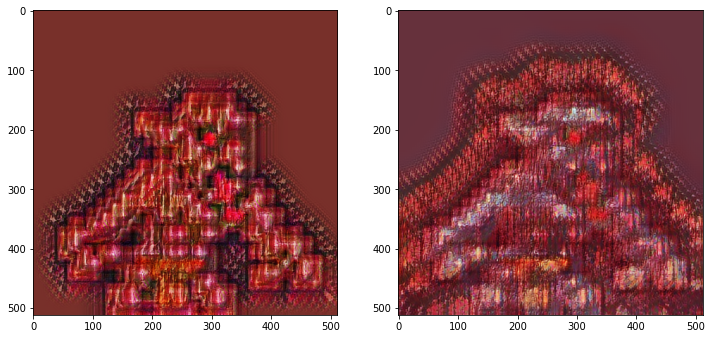

In [51]:
#style transfer
img_transformed1 = hub_module1(tf.constant(content_image), tf.constant(style_image))[0]
img_transformed2 = hub_module2(tf.constant(content_image), tf.constant(style_image))[0]

plt.subplot(1,2,1)
plt.imshow(img_transformed1[0])

plt.subplot(1,2,2)
plt.imshow(img_transformed2[0])

plt.show()

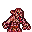

True

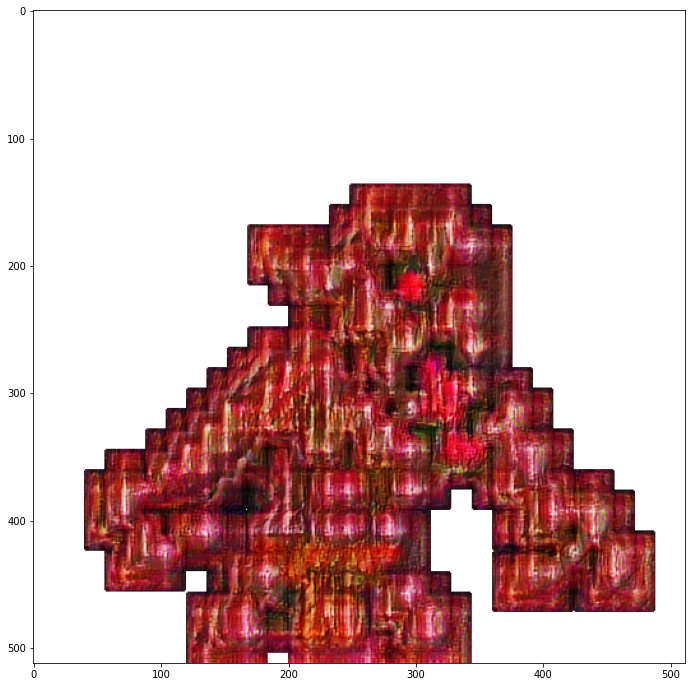

In [48]:
# 테스트 코드 (hub_module1)

# style transfer
img_transformed1 = hub_module1(tf.constant(content_image), tf.constant(style_image))[0]

# 원본 이미지 크기 기억하기
origin_image = cv.imread(content_location, cv.IMREAD_UNCHANGED)
origin_image_shape = origin_image.shape

# model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
shape = img_transformed1[0].shape
x, y = shape[0], shape[1]
origin_image_resized = cv.resize(origin_image, dsize=(y,x))

# alpha channel 추가
final = img_transformed1[0].numpy()
final = cv.cvtColor(np.float32(img_transformed1[0]), cv.COLOR_RGB2RGBA)
final[:, :, 3] = origin_image_resized[:,:,3]

plt.imshow(final)

# final image 사이즈를 original image 사이즈로 변환
x, y = origin_image_shape[0], origin_image_shape[1]
final = cv.resize(final, dsize=(y,x))

# float to int 클리핑
final = (final * 255).astype(np.uint)

# plt 기준의 bgr을 cv 기준의 rgb로 변경
b, g, r, a = cv.split(final)
final = cv.merge([r,g,b,a])

#저장
cv2_imshow(final)
cv.imwrite("/content/a.png", final)

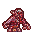

True

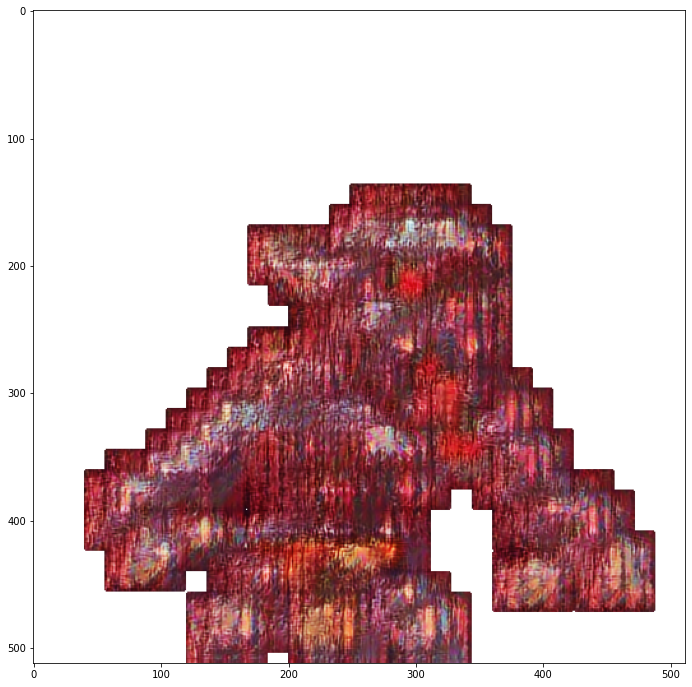

In [49]:
# 테스트 코드 (hub_module2)

# style transfer
img_transformed2 = hub_module2(tf.constant(content_image), tf.constant(style_image))[0]

# 원본 이미지 크기 기억하기
origin_image = cv.imread(content_location, cv.IMREAD_UNCHANGED)
origin_image_shape = origin_image.shape

# model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
shape = img_transformed2[0].shape
x, y = shape[0], shape[1]
origin_image_resized = cv.resize(origin_image, dsize=(y,x))

# alpha channel 추가
final = img_transformed2[0].numpy()
final = cv.cvtColor(np.float32(img_transformed2[0]), cv.COLOR_RGB2RGBA)
final[:, :, 3] = origin_image_resized[:,:,3]

plt.imshow(final)

# final image 사이즈를 original image 사이즈로 변환
x, y = origin_image_shape[0], origin_image_shape[1]
final = cv.resize(final, dsize=(y,x))

# float to int 클리핑
final = (final * 255).astype(np.uint)

# plt 기준의 bgr을 cv 기준의 rgb로 변경
b, g, r, a = cv.split(final)
final = cv.merge([r,g,b,a])

#저장
cv2_imshow(final)
cv.imwrite("/content/a.png", final)

In [50]:
# 경로 설정 명세서
platform_path = platform.platform()

IsColab = "bionic" in platform_path
if IsColab:
  style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/*"
  content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/*"
  styled_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Styled_Images/"
else:
  style_location = 'Style_Images/*'
  content_location = "Content_Images/*"
  styled_location = "Styled_Images/"

# 해당 폴더 내에 존재하는 모든 폴더 리스트 불러오기
style_folder_list = glob.glob(style_location)
style_images_list = glob.glob(style_folder_list[0] + "/*")

# Style_location
# Style_Images/TEXTURE/*.jpg or png

# style_images_list, style_image 활용
# style_image = style_images_list[index]

# Content_location
  # Content_Images/ASSET_NAME/*.png
content_folder_list = glob.glob(content_location) # Content_Images/ASSET_NAME

# content_images_list, content_image 활용
# content_images_list = glob.glob(content_folder_list[index] + "/*")
# content_image = style_images_list[index]

# Styled_location
  # Styled_Images/ASSET_NAME/*.png
# asset_name = os.path.split(content_folder_list[index])

# 폴더 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)


# 구글 코랩에서 장시간 사용하기
# F12 개발자 모드 후 Console에 입력



```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```


```javascript
function CleanCurrentOutput(){ 
    var btn = document.querySelector(".output-icon.clear_outputs_enabled.output-icon-selected[title$='현재 실행 중...'] iron-icon[command=clear-focused-or-selected-outputs]"); 
    if(btn) { console.log("30분마다 출력 지우기");
     btn.click(); 
    } 
} 
setInterval(CleanCurrentOutput,1000*60*30);
```

In [ ]:
## main code
import time
start = time.time()

# ★사용 모델명★
model_name = "Mobilenets1"

# 스타일 폴더 리스트
for SF_index, SF_value in enumerate(style_folder_list):
  style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
  style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc
  style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
  for SI_index, SI_value in enumerate(style_images_list):
    style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
    # 스타일 이미지 선택
    print(SI_value)

    # 콘텐트 폴더 리스트
    for CF_index, CF_value in enumerate(content_folder_list):

      #콘텐트 이미지 리스트
      content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
      content_images_list = natsort.natsorted(content_images_list)

      # 스타일 전이
      for CI_index, CI_value in enumerate(content_images_list):
        location = CI_value

        # 저장 경로 생성
        asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
        asset_name = os.path.split(CI_value)

        save_folder_model = styled_location + model_name
        save_folder_style = save_folder_model + "/" + style_folder_name[1]
        save_folder_style_index = save_folder_style + "/" + style_image_name[1]
        save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
        createFolder(save_folder_style) # VGG19, AdaIN, efficientNet
        createFolder(save_folder_style) # horror, ice, dark
        createFolder(save_folder_style_index) # horror1, horror2, horror3
        createFolder(save_folder_style_index_content) # goblin, zombie, male

        save_path = save_folder_style_index_content + "/"
        save_path = save_path + asset_folder[1] + f'_{CI_index}_final.png'

        # 이미 있는 파일이면 건너뛰기
        if os.path.exists(save_path):
          continue
        else:

          # 경로에 있는 이미지 읽기
          content_image, content_shape = load_img(location)
          style_image, style_shape = load_img(SI_value)

          # style transfer
          img_transformed1 = hub_module1(tf.constant(content_image), tf.constant(style_image))[0]

          # 원본 이미지 크기 기억하기
          origin_image = cv.imread(location, cv.IMREAD_UNCHANGED)
          origin_image_shape = origin_image.shape

          # model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
          shape = img_transformed1[0].shape
          x, y = shape[0], shape[1]
          origin_image_resized = cv.resize(origin_image, dsize=(y,x))

          # alpha channel 추가
          final = img_transformed1[0].numpy()
          final = cv.cvtColor(np.float32(img_transformed1[0]), cv.COLOR_RGB2RGBA)
          final[:, :, 3] = origin_image_resized[:,:,3]

          # final image 사이즈를 original image 사이즈로 변환
          x, y = origin_image_shape[0], origin_image_shape[1]
          final = cv.resize(final, dsize=(y,x))

          # float to int 클리핑
          final = (final * 255).astype(np.uint)

          # plt 기준의 bgr을 cv 기준의 rgb로 변경
          b, g, r, a = cv.split(final)
          final = cv.merge([r,g,b,a])

          #저장
          cv.imwrite(save_path, final)
          
end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [ ]:
## main code
import time
start = time.time()

# ★사용 모델명★
model_name = "Mobilenets2"

# 스타일 폴더 리스트
for SF_index, SF_value in enumerate(style_folder_list):
  style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
  style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc
  style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
  for SI_index, SI_value in enumerate(style_images_list):
    style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
    # 스타일 이미지 선택
    print(SI_value)

    # 콘텐트 폴더 리스트
    for CF_index, CF_value in enumerate(content_folder_list):

      #콘텐트 이미지 리스트
      content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
      content_images_list = natsort.natsorted(content_images_list)

      # 스타일 전이
      for CI_index, CI_value in enumerate(content_images_list):
        location = CI_value

        # 저장 경로 생성
        asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
        asset_name = os.path.split(CI_value)

        save_folder_model = styled_location + model_name
        save_folder_style = save_folder_model + "/" + style_folder_name[1]
        save_folder_style_index = save_folder_style + "/" + style_image_name[1]
        save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
        createFolder(save_folder_style) # VGG19, AdaIN, efficientNet
        createFolder(save_folder_style) # horror, ice, dark
        createFolder(save_folder_style_index) # horror1, horror2, horror3
        createFolder(save_folder_style_index_content) # goblin, zombie, male

        save_path = save_folder_style_index_content + "/"
        save_path = save_path + asset_folder[1] + f'_{CI_index}_final.png'

        # 이미 있는 파일이면 건너뛰기
        if os.path.exists(save_path):
          continue
        else:

          # 경로에 있는 이미지 읽기
          content_image, content_shape = load_img(location)
          style_image, style_shape = load_img(SI_value)

          # style transfer
          img_transformed2 = hub_module2(tf.constant(content_image), tf.constant(style_image))[0]

          # 원본 이미지 크기 기억하기
          origin_image = cv.imread(location, cv.IMREAD_UNCHANGED)
          origin_image_shape = origin_image.shape

          # model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
          shape = img_transformed2[0].shape
          x, y = shape[0], shape[1]
          origin_image_resized = cv.resize(origin_image, dsize=(y,x))

          # alpha channel 추가
          final = img_transformed2[0].numpy()
          final = cv.cvtColor(np.float32(img_transformed2[0]), cv.COLOR_RGB2RGBA)
          final[:, :, 3] = origin_image_resized[:,:,3]

          # final image 사이즈를 original image 사이즈로 변환
          x, y = origin_image_shape[0], origin_image_shape[1]
          final = cv.resize(final, dsize=(y,x))

          # float to int 클리핑
          final = (final * 255).astype(np.uint)

          # plt 기준의 bgr을 cv 기준의 rgb로 변경
          b, g, r, a = cv.split(final)
          final = cv.merge([r,g,b,a])

          #저장
          cv.imwrite(save_path, final)
          
end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))